<a href="https://colab.research.google.com/github/BindyaPhilip/split_folder/blob/main/image_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import zipfile
import os
#paths
train_dir = '/content/drive/MyDrive/image_analysis/data/train'
test_dir = '/content/drive/MyDrive/image_analysis/data/test'
val_dir = '/content/drive/MyDrive/image_analysis/data/val'


# Verify directories exist
for dir_path in [train_dir, test_dir, val_dir]:
    if os.path.exists(dir_path):
        print(f"Directory exists: {dir_path}")
        print(f"Contents: {os.listdir(dir_path)}")
    else:
        print(f"Directory not found: {dir_path}")



Directory exists: /content/drive/MyDrive/image_analysis/data/train
Contents: ['common_rust', 'healthy', 'other_disease']
Directory exists: /content/drive/MyDrive/image_analysis/data/test
Contents: ['common_rust', 'healthy', 'other_disease']
Directory exists: /content/drive/MyDrive/image_analysis/data/val
Contents: ['other_disease', 'common_rust', 'healthy']


In [ ]:
# Import necessary libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
!pip install tensorflow


In [ ]:
# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


Training Image preprocessing

In [ ]:
# Load datasets
training_set = datagen.flow_from_directory(
    train_dir,  # Directly use the train directory
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',  # Multi-class
    shuffle=True
)

Found 3349 images belonging to 3 classes.


In [ ]:
val_test_datagen = ImageDataGenerator(rescale=1./255)
validation_set = val_test_datagen.flow_from_directory(
    val_dir,  # Directly use the val directory
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
testing_set = val_test_datagen.flow_from_directory(
    test_dir,  # Directly use the test directory
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 419 images belonging to 3 classes.
Found 420 images belonging to 3 classes.


In [ ]:
# Print class names
class_names = list(training_set.class_indices.keys())
print("Class Names:", class_names)  # e.g., ['healthy', 'common_rust', 'other_disease']

Class Names: ['common_rust', 'healthy', 'other_disease']


BUILDING THE MODEL

In [ ]:
# Define the model
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    Conv2D(32, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(256, 3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(256, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes
])

COMPILING THE MODEL

In [ ]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 16, 16, 256)         │         590,0

 Total params: 9,566,755 (36.49 MB)

 Trainable params: 9,564,835 (36.49 MB)

 Non-trainable params: 1,920 (7.50 KB)

TRAINING THE MODEL

In [ ]:
# Train the model
training_history = model.fit(
    training_set,
    epochs=20,
    validation_data=validation_set,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 393s 4s/step - accuracy: 0.9726 - loss: 0.0769 - val_accuracy: 0.9642 - val_loss: 0.1148 - learning_rate: 2.0000e-05
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 456s 4s/step - accuracy: 0.9757 - loss: 0.0853 - val_accuracy: 0.9594 - val_loss: 0.1165 - learning_rate: 2.0000e-05
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 386s 4s/step - accuracy: 0.9654 - loss: 0.0791 - val_accuracy: 0.9618 - val_loss: 0.1149 - learning_rate: 2.0000e-05
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 393s 4s/step - accuracy: 0.9759 - loss: 0.0599 - val_accuracy: 0.9594 - val_loss: 0.1185 - learning_rate: 4.0000e-06


In [ ]:
print(f"Training Accuracy: {training_history}")

Training Accuracy: <keras.src.callbacks.history.History object at 0x7f6536eccb50>


MODEL EVALUATION

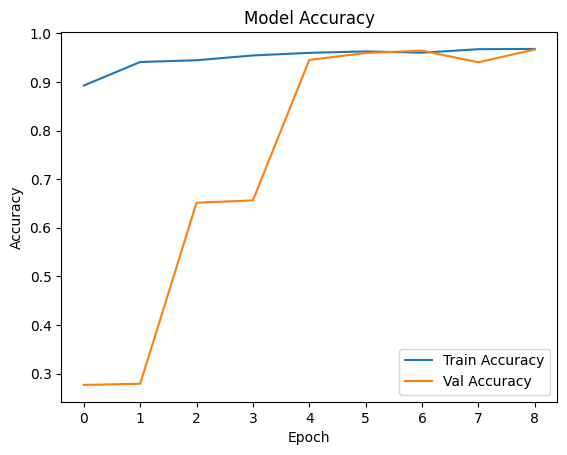

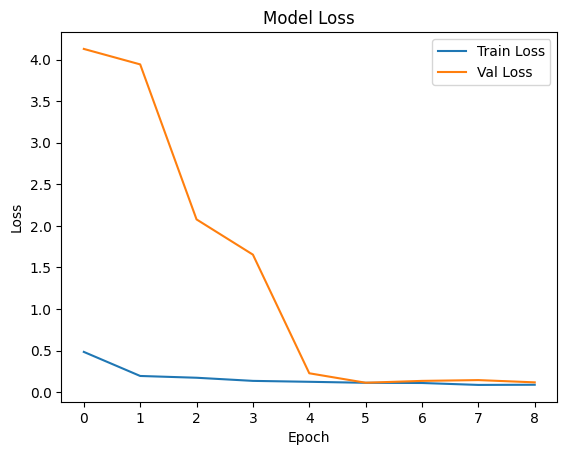

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(training_history.history['accuracy'], label='Train Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(training_history.history['loss'], label='Train Loss')
plt.plot(training_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
#Model evaluation on training set
train_loss, train_acc = model.evaluate(training_set)

105/105 ━━━━━━━━━━━━━━━━━━━━ 101s 958ms/step - accuracy: 0.9714 - loss: 0.0897


In [ ]:
print(train_loss, train_acc)

0.09040290117263794 0.9686473608016968


In [ ]:
#model evaluation on validation set
val_loss, val_acc = model.evaluate(validation_set)

14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 789ms/step - accuracy: 0.9672 - loss: 0.0955


In [ ]:
print(val_loss, val_acc)

0.11267894506454468 0.9594271779060364


In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(testing_set)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 117s 9s/step - accuracy: 0.9676 - loss: 0.0802
Test Loss: 0.0748, Test Accuracy: 0.9738


SAVING THE MODEL

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/image_analysis/data/multi_class_model.keras')

In [ ]:
#recording model history in json
import json
with open('training_history.json', 'w') as f:
    json.dump(training_history.history, f)


PREDICTING

In [ ]:
# Prediction on a single image
from google.colab import files
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

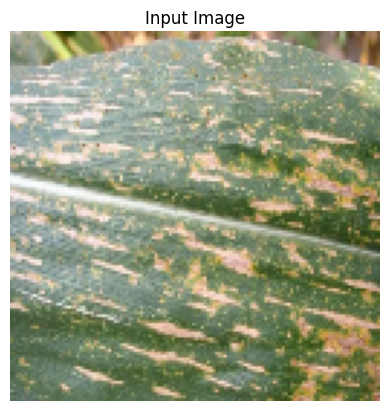

In [ ]:
# Load and preprocess the image
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
plt.imshow(img)
plt.axis('off')
plt.title("Input Image")
plt.show()


img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

In [ ]:
# Predict
prediction = model.predict(img_array)[0]
predicted_class_idx = np.argmax(prediction)
predicted_class = class_names[predicted_class_idx]
confidence = prediction[predicted_class_idx]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


In [ ]:
# Display result
print(f"Predicted Class: {predicted_class} (Confidence: {confidence:.2f})")